# Get started
## Before everything started: Jargon
1. ECAL: Electro-magentic calorimeter, mainly aims to measure energy of electrons and gammas
2. PicoCal: Name of Run5 ECAL, by pico it means to have very good(pico-second level time resolution)
3. Module: minimum detector unit in **manufactoring** , with $12.1 \times 12.1 cm^2$ in size.
4. Cell: minimum detector unit in **readout**, more specifically, it refers to a small part of detector that is readout together.
5. Channel: similar with Cell, but focus on the readout part(PMT) rather than detector part
... For more jargon, please remind me ...
 
## Output files from simulation

For correct input sample path
```
cd /root/path
ln -s /nishome/songyx/disk402/WORK/ECAL_ML_Recon/input_sample ./
cd -
```
There are 2 types of output files from simulation:
1. OutTrig_*.root
2. flux_*.root
They are connected by index in the wildcard.

### OutTrig_*.root

They mainly contain information of readout from PMTs(namely each cell) in the ```cell``` tree(see [here](#readout-info) ). Moreover, they also contain geometric information of each cell/module(see [here](#geo-info)).

<a id="geo-info"></a>

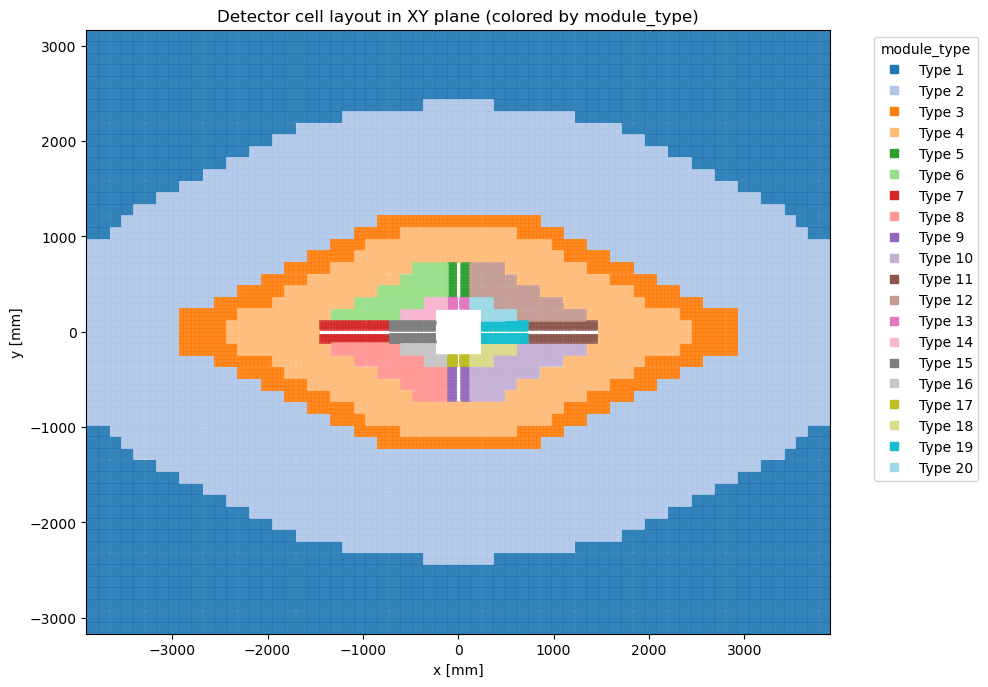

In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# 打开 TTree，读取必要字段
with uproot.open("../input_sample/Run5_2023_baseline/OutTrigd_11451.root") as file:
    tree = file["cells"]
    arrays = tree.arrays(["x_mm", "y_mm", "dx_mm", "dy_mm", "module_type"])

x = arrays["x_mm"]
y = arrays["y_mm"]
dx = arrays["dx_mm"]
dy = arrays["dy_mm"]
types = arrays["module_type"]

# 创建绘图对象
fig, ax = plt.subplots(figsize=(10, 10))

# 为不同 module_type 指定颜色
unique_types = np.unique(types)
type_color_map = {t: plt.cm.tab20(i % 20) for i, t in enumerate(unique_types)}

# 绘制每个 cell 的矩形框
for xi, yi, dxi, dyi, t in zip(x, y, dx, dy, types):
    color = type_color_map[t]
    rect = patches.Rectangle(
        (xi - dxi/2, yi - dyi/2),  # 左下角坐标
        dxi, dyi,
        linewidth=0.5,
        edgecolor=color,
        facecolor=color,
        alpha=0.7
    )
    ax.add_patch(rect)

# 设置轴范围和标签
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_xlim(np.min(x - dx / 2), np.max(x + dx / 2))
ax.set_ylim(np.min(y - dy / 2), np.max(y + dy / 2))
ax.set_aspect("equal")
ax.set_title("Detector cell layout in XY plane (colored by module_type)")

# 可选：添加 legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='s', linestyle='None',
                          color=type_color_map[t], label=f"Type {t}")
                   for t in unique_types]
ax.legend(handles=legend_elements, title="module_type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
OutTrig_path = "../input_sample/Run5_2023_baseline/OutTrigd_11451.root"

<a id="readout-info"></a>
Read readout information from ```tree```:

1. branch ```mod*_ph``` : number of optical photon collected by readout
2. branch ```mod*_t``` : timestamp of this channel's trigger

In [3]:
import uproot

file = uproot.open(OutTrig_path)
tree = file["tree"]

# 第一步：快速只读 branch 名，不读取内容
all_branch_names = tree.keys()

# 第二步：找出所有你关心的 branch 中非空的
nonempty_branches = []
for name in all_branch_names:
    if name.endswith("_ph") or name.endswith("_t"):
        arr = tree[name].array(entry_start=0, entry_stop=1)
        if len(arr[0]) > 0:  # 非空 vector
            nonempty_branches.append(name)

print(f"有意义的 branch 数量: {len(nonempty_branches)}")
print(f"有意义的 branch 名称: {nonempty_branches}")

# 第三步：只读取这些有意义的 branch
readout_arrays = tree.arrays(nonempty_branches)

import re
import awkward as ak
record = readout_arrays[0]  # 单条 entry 的 record（ak.Record）

# 提取模块编号并分组
module_dict = {}
pattern = re.compile(r"mod(\d+)_(ph|t)")

for key in record.fields:
    match = pattern.fullmatch(key)
    if not match:
        continue
    mod_id = int(match.group(1))
    typ = match.group(2)
    if mod_id not in module_dict:
        module_dict[mod_id] = {}
    module_dict[mod_id][typ] = ak.to_list(record[key])  # 也可以不转为 list，看你想要的展示方式

# 按模块号排序并打印
for mod_id in sorted(module_dict):
    ph = module_dict[mod_id].get("ph", [])
    t = module_dict[mod_id].get("t", [])
    print(f"mod{mod_id}:")
    print(f"    ph: {ph}")
    print(f"    t : {t}")

有意义的 branch 数量: 74
有意义的 branch 名称: ['mod1089_ph', 'mod2765_ph', 'mod2893_ph', 'mod3099_ph', 'mod3140_ph', 'mod3166_ph', 'mod3197_ph', 'mod3209_ph', 'mod3218_ph', 'mod3221_ph', 'mod3224_ph', 'mod3228_ph', 'mod3231_ph', 'mod3233_ph', 'mod3234_ph', 'mod3245_ph', 'mod3246_ph', 'mod3257_ph', 'mod3258_ph', 'mod3260_ph', 'mod3261_ph', 'mod3265_ph', 'mod3272_ph', 'mod3292_ph', 'mod3294_ph', 'mod3295_ph', 'mod3297_ph', 'mod3299_ph', 'mod3301_ph', 'mod3302_ph', 'mod3303_ph', 'mod3304_ph', 'mod3305_ph', 'mod3306_ph', 'mod3307_ph', 'mod3308_ph', 'mod3310_ph', 'mod1089_t', 'mod2765_t', 'mod2893_t', 'mod3099_t', 'mod3140_t', 'mod3166_t', 'mod3197_t', 'mod3209_t', 'mod3218_t', 'mod3221_t', 'mod3224_t', 'mod3228_t', 'mod3231_t', 'mod3233_t', 'mod3234_t', 'mod3245_t', 'mod3246_t', 'mod3257_t', 'mod3258_t', 'mod3260_t', 'mod3261_t', 'mod3265_t', 'mod3272_t', 'mod3292_t', 'mod3294_t', 'mod3295_t', 'mod3297_t', 'mod3299_t', 'mod3301_t', 'mod3302_t', 'mod3303_t', 'mod3304_t', 'mod3305_t', 'mod3306_t', 'mod

['mod1089_ph', 'mod2765_ph', 'mod2893_ph', 'mod3099_ph', 'mod3140_ph', 'mod3166_ph', 'mod3197_ph', 'mod3209_ph', 'mod3218_ph', 'mod3221_ph', 'mod3224_ph', 'mod3228_ph', 'mod3231_ph', 'mod3233_ph', 'mod3234_ph', 'mod3245_ph', 'mod3246_ph', 'mod3257_ph', 'mod3258_ph', 'mod3260_ph', 'mod3261_ph', 'mod3265_ph', 'mod3272_ph', 'mod3292_ph', 'mod3294_ph', 'mod3295_ph', 'mod3297_ph', 'mod3299_ph', 'mod3301_ph', 'mod3302_ph', 'mod3303_ph', 'mod3304_ph', 'mod3305_ph', 'mod3306_ph', 'mod3307_ph', 'mod3308_ph', 'mod3310_ph', 'mod1089_t', 'mod2765_t', 'mod2893_t', 'mod3099_t', 'mod3140_t', 'mod3166_t', 'mod3197_t', 'mod3209_t', 'mod3218_t', 'mod3221_t', 'mod3224_t', 'mod3228_t', 'mod3231_t', 'mod3233_t', 'mod3234_t', 'mod3245_t', 'mod3246_t', 'mod3257_t', 'mod3258_t', 'mod3260_t', 'mod3261_t', 'mod3265_t', 'mod3272_t', 'mod3292_t', 'mod3294_t', 'mod3295_t', 'mod3297_t', 'mod3299_t', 'mod3301_t', 'mod3302_t', 'mod3303_t', 'mod3304_t', 'mod3305_t', 'mod3306_t', 'mod3307_t', 'mod3308_t', 'mod3310_t']


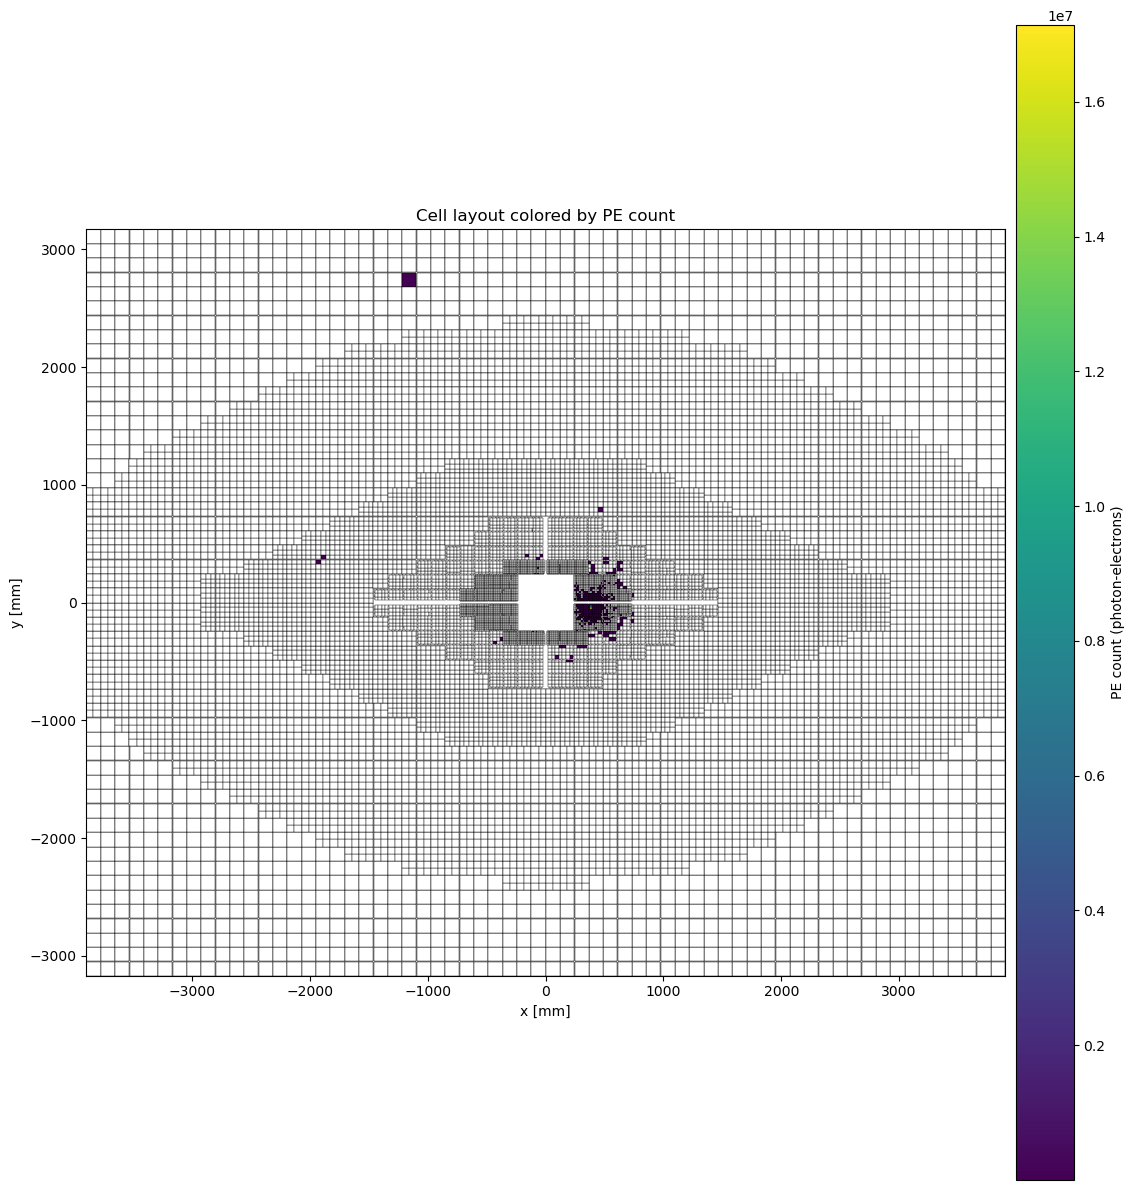

In [4]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import re

# ---------- Step 1: Load cell geometry ----------
with uproot.open(OutTrig_path) as file:
    cells_tree = file["cells"]
    cells = cells_tree.arrays(["x_mm", "y_mm", "dx_mm", "dy_mm", "module_id_in_calo", "cell_id_in_module"])

x = cells["x_mm"]
y = cells["y_mm"]
dx = cells["dx_mm"]
dy = cells["dy_mm"]
mod_id = cells["module_id_in_calo"]
cell_id = cells["cell_id_in_module"]

# ---------- Step 3: Extract PE for each cell ----------
pe_list = []
print(readout_arrays.fields)  # 打印所有字段名，检查是否有 mod*_ph
for mid, cid in zip(mod_id, cell_id):
    branch_name = f"mod{mid}_ph"
    if branch_name in readout_arrays.fields:
        vec = readout_arrays[branch_name][0]  # arrays 是 length-1 的 ak.Array
        # print(vec)
        pe = vec[cid] if cid < len(vec) else 0
    else:
        pe = 0
    pe_list.append(pe)

pe_array = np.array(pe_list)
print("Non-zero PE count:", np.count_nonzero(pe_array))



# ---------- Step 4: Colormap setup ----------
# 非0值使用 colormap，0 值为白色（或可设置 alpha）
vmin = np.min(pe_array[pe_array > 0]) if np.any(pe_array > 0) else 0.1
vmax = np.max(pe_array)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# ---------- Step 5: Draw ----------
fig, ax = plt.subplots(figsize=(12, 12))

for xi, yi, dxi, dyi, pe in zip(x, y, dx, dy, pe_array):
    if pe > 0:
        color = cmap(norm(pe))
    else:
        color = "white"
    rect = patches.Rectangle(
        (xi - dxi / 2, yi - dyi / 2),
        dxi, dyi,
        facecolor=color,
        edgecolor='black',
        linewidth=0.3
    )
    ax.add_patch(rect)

# 坐标设置
ax.set_xlim(np.min(x - dx / 2), np.max(x + dx / 2))
ax.set_ylim(np.min(y - dy / 2), np.max(y + dy / 2))
ax.set_aspect("equal")
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_title("Cell layout colored by PE count")

# 添加 colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 空数据也能创建 colorbar
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label("PE count (photon-electrons)")

plt.tight_layout()
plt.show()
